In [1]:
import sqlite3
import numpy as np
from ctypes import *
import sys
import os
import baf2sql
import matplotlib.pyplot as plt

Specified BAF has 159 spectra with line and profile data.


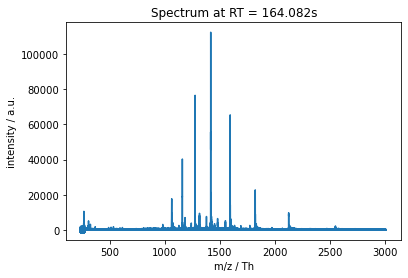

In [2]:
analysis_dir = "example_analysis.d"


if sys.version_info.major == 2:
    # note: assuming a european Windows here...
    analysis_dir = unicode(analysis_dir, 'cp1252')
    
baf_fn = os.path.join(analysis_dir, "analysis.baf")
sqlite_fn = baf2sql.getSQLiteCacheFilename(baf_fn)
conn = sqlite3.connect(sqlite_fn)

# --- Count spectra
q = conn.execute("SELECT COUNT(*) FROM Spectra "
                 "WHERE LineMzId NOT NULL AND ProfileMzId NOT NULL")
row = q.fetchone()
N = row[0]
print("Specified BAF has {} spectra with line and profile data.".format(N))

# --- Plot TIC and BPC over MS^1 spectra
q = conn.execute("SELECT Rt, SumIntensity, MaxIntensity FROM Spectra s "
                 "JOIN AcquisitionKeys ak ON s.AcquisitionKey = ak.Id "
                 "WHERE ak.MsLevel = 0 "
                 "ORDER BY s.ROWID")
data = [ row for row in q ]
rt = [ row[0] for row in data ]
tic = [ row[1] for row in data ]
bpc = [ row[2] for row in data ]

# plt.figure()
# plt.plot(rt, tic)
# # plt.hold(True)
# plt.plot(rt, bpc, '--')
# plt.xlabel('retention time / s')
# plt.ylabel('intensity / a.u.')
# plt.legend(['TIC', 'BPC'])
# plt.show()


# --- Plot spectrum with largest base-peak intensity

np_bpc = np.array(bpc, dtype = 'float')
rt0 = rt[np.nanargmax(np_bpc)]


q = conn.execute("SELECT LineMzId, LineIntensityId, ProfileMzId, ProfileIntensityId FROM Spectra "
                 "WHERE ABS(Rt - {}) < 1e-8".format(rt0))
                 
row = q.fetchone()

bs = baf2sql.BinaryStorage(baf_fn)


if row != None:

    plt.figure()

    bs = baf2sql.BinaryStorage(baf_fn)
    
    if row[2] != None and row[3] != None:
        profile_mz = bs.readArrayDouble(row[2])
        profile_int = bs.readArrayDouble(row[3])
        plt.plot(profile_mz, profile_int)

    if row[0] != None and row[1] != None:
        line_mz = bs.readArrayDouble(row[0])
        line_int = bs.readArrayDouble(row[1])

        # stem() can take quite some time, so we reduce data for this example:
        max_points = 100;
        if len(line_mz) > max_points:
            line_mz = line_mz[0:max_points]
            line_int = line_int[0:max_points]
        # plt.hold(True)
        plt.stem(line_mz, line_int)

    plt.xlabel("m/z / Th")
    plt.ylabel('intensity / a.u.')
    plt.title("Spectrum at RT = {}s".format(rt0))
    plt.show()
    
else:
    print("No spectrum found...")



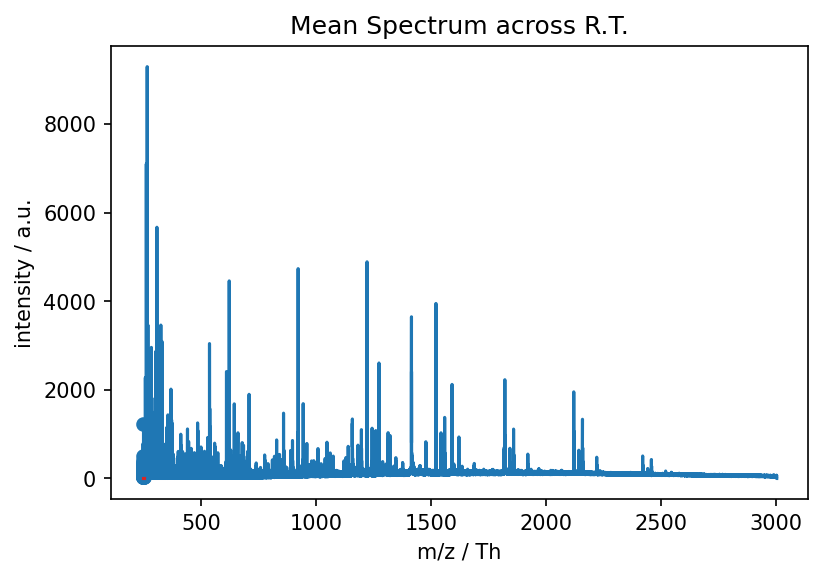

In [4]:
# --- Plot mean spectrum 

np_bpc = np.array(bpc, dtype = 'float')

spec_vals = {'profile_mz':[], 'profile_int':[], 'line_mz':[], 'line_int':[]}

for i in rt: 

    q = conn.execute("SELECT LineMzId, LineIntensityId, ProfileMzId, ProfileIntensityId FROM Spectra "
                    "WHERE ABS(Rt - {}) < 1e-8".format(i))
                
    row = q.fetchone()

    bs = baf2sql.BinaryStorage(baf_fn)

    if not all(row) == False: # check for None values
        
    #     plt.figure()

        bs = baf2sql.BinaryStorage(baf_fn)

        profile_mz = bs.readArrayDouble(row[2])
        profile_int = bs.readArrayDouble(row[3])

        spec_vals['profile_mz'].append(profile_mz)
        spec_vals['profile_int'].append(profile_int)


        line_mz = bs.readArrayDouble(row[0])
        line_int = bs.readArrayDouble(row[1])

        # stem() can take quite some time, so we reduce data for this example:

        max_points = 100;

        if len(line_mz) > max_points:
            line_mz = line_mz[0:max_points]
            line_int = line_int[0:max_points]
        
        spec_vals['line_mz'].append(line_mz)
        spec_vals['line_int'].append(line_int)
        








# convert resulting spectra values into arrays
np_profile_mz = np.array(spec_vals['profile_mz'])
np_profile_int = np.array(spec_vals['profile_int'])

np_line_mz = np.array(spec_vals['line_mz'])
np_line_int = np.array(spec_vals['line_int'])

# take average of arrays 
mean_profile_mz = np.average(np_profile_mz, axis = 0)
mean_profile_int = np.average(np_profile_int, axis = 0)
mean_line_mz = np.average(np_profile_mz, axis = 0)
mean_line_int = np.average(np_profile_mz, axis = 0)

plt.figure(dpi = 150)

plt.plot(mean_profile_mz, mean_profile_int)
plt.stem(line_mz, line_int)

plt.xlabel("m/z / Th")
plt.ylabel('intensity / a.u.')
plt.title("Mean Spectrum across R.T.")
plt.show()

    #     if row[0] != None and row[1] != None:
    #         line_mz = bs.readArrayDouble(row[0])
    #         line_int = bs.readArrayDouble(row[1])

    #         # stem() can take quite some time, so we reduce data for this example:
    #         max_points = 100;
    #         if len(line_mz) > max_points:
    #             line_mz = line_mz[0:max_points]
    #             line_int = line_int[0:max_points]
    #         # plt.hold(True)
            
    #         plt.stem(line_mz, line_int)

    #     plt.xlabel("m/z / Th")
    #     plt.ylabel('intensity / a.u.')
    #     plt.title("Spectrum at RT = {}s".format(rt0))
    #     plt.show()

    # else:
    #     print("No spectrum found...")



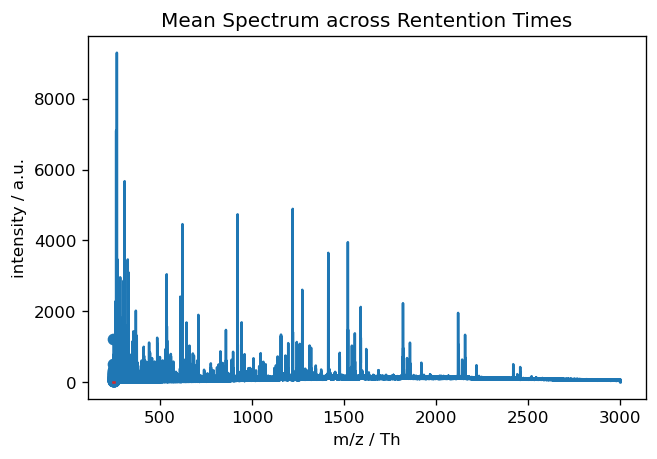

In [7]:
# --- Plot mean spectrum 

np_bpc = np.array(bpc, dtype = 'float')

spec_vals = {'profile_mz':[], 'profile_int':[], 'line_mz':[], 'line_int':[]}

for i in rt: 

    q = conn.execute("SELECT LineMzId, LineIntensityId, ProfileMzId, ProfileIntensityId FROM Spectra "
                    "WHERE ABS(Rt - {}) < 1e-8".format(i))
                
    row = q.fetchone()

    bs = baf2sql.BinaryStorage(baf_fn)

    if not all(row) == False: # check for None values

        bs = baf2sql.BinaryStorage(baf_fn)

        profile_mz = bs.readArrayDouble(row[2])
        profile_int = bs.readArrayDouble(row[3])

        spec_vals['profile_mz'].append(profile_mz)
        spec_vals['profile_int'].append(profile_int)


        line_mz = bs.readArrayDouble(row[0])
        line_int = bs.readArrayDouble(row[1])

        # stem() can take quite some time, so we reduce data for this example:

        max_points = 100;

        if len(line_mz) > max_points:
            line_mz = line_mz[0:max_points]
            line_int = line_int[0:max_points]
        
        spec_vals['line_mz'].append(line_mz)
        spec_vals['line_int'].append(line_int)


# convert resulting spectra values into arrays
np_profile_mz = np.array(spec_vals['profile_mz'])
np_profile_int = np.array(spec_vals['profile_int'])

np_line_mz = np.array(spec_vals['line_mz'])
np_line_int = np.array(spec_vals['line_int'])

# take average of arrays 
mean_profile_mz = np.average(np_profile_mz, axis = 0)
mean_profile_int = np.average(np_profile_int, axis = 0)
mean_line_mz = np.average(np_profile_mz, axis = 0)
mean_line_int = np.average(np_profile_mz, axis = 0)

plt.figure(dpi = 120)

plt.plot(mean_profile_mz, mean_profile_int)
plt.stem(line_mz, line_int)

plt.xlabel("m/z / Th")
plt.ylabel('intensity / a.u.')
plt.title("Mean Spectrum across Rentention Times")
plt.show()


